### 0 Setup

#### 0.1 Imports

In [1]:
import os.path

import episcanpy as epi
import scanpy as sc
import numpy as np
import anndata as ad
import pandas as pd
from scipy.sparse import issparse, csr_matrix, csc_matrix, hstack
import tempfile
import requests

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import utils


#### 0.1 Variables

#### Project setup variables

In [2]:
# Input paths
input_folder = "/mnt/workspace_stud/mbentse/catlas_objects/"
input_filename = "heart_lv_SM-IOBHO.h5ad"
h5ad_path = f"{input_folder}/{input_filename}"

# Output paths
data_folder = "/mnt/workspace_stud/allstud/wp1/data"
out_filename = "heart_lv_SM-IOBHO.h5ad"
out_file = f"{data_folder}/2024_02_20/{out_filename}"

# Uropa installation path
uropa_path = "~/.conda/envs/datenanalyse/bin/uropa"

#### Important variables

In [3]:
## Cell Filtering 
# minimum count of features a cell needs to have
min_features = 100
# maximum count of features a cell needs to have, as a percentile of all features
max_features_percentile = 100 - 1.5

## Feature Filtering
# minimum count of cells a features needs to have
min_cells = 1
# maximum count of cells a feature needs to have, as a percentile of all cells
max_cells_percentile = 100 - 2


# Minimum size of ontologies in percentage of cells
ontology_threshold = 1

# PCA dimensions
pca_components = 25

# Clustering parameters for the different Clusters to be performed.
# [ METHOD , PARAM ]
# Methods are either: louvain , leiden or kmeans
# louvain and leiden params are: Resolution
# kmeans params are : k-clusters, the count of clusters to be created by kmeans
cluster_params = [
    ['louvain', 0.1],
    ['louvain', 0.25],
    ['louvain', 0.5],
    ['louvain', 1],
    ['leiden', 0.1],
    ['leiden', 0.25],
    ['leiden', 0.5],
    ['leiden', 1],
    ['kmeans', 7],
    ['kmeans', 10],
    ['kmeans', 13],
    ['kmeans', 16]
]

#### Other variables

In [4]:
# n_neighbors
n_neighbors = 15
neighbors_method  = 'umap'
neighbors_metric = 'euclidean'

# UMAP
umap_spread= 2.5
umap_minDist= 0.1

#### Cell-Metadata paths

In [5]:
!mkdir -p  {data_folder}/catlas_metadata
metadata_url = "http://catlas.org/catlas_downloads/humantissues/Cell_metadata.tsv.gz"
metadata_path = f"{data_folder}/catlas_metadata/Cell_metadata.tsv"
ontology_url = "http://catlas.org/catlas_downloads/humantissues/Cell_ontology.tsv"
ontology_path = f"{data_folder}/catlas_metadata/Cell_ontology.tsv"

#### Gene-Metadata paths

In [6]:
gtf_url="https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_38/gencode.v38.annotation.gtf.gz"
gtf_filename="gencode.v38.annotation.gtf"
gtf_path=f"{data_folder}/{gtf_filename}"

### 1. Read adata 

In [7]:
adata = epi.read_h5ad(h5ad_path)

In [8]:
shape = adata.X.shape
print(f'Adata shape: {shape[0]} cells x {shape[1]} features')

Adata shape: 9210 cells x 1154611 features


In [9]:
adata.uns["shapes"] = [shape]

def calculate_shape_change(adata):
    old_shape = adata.uns["shapes"][-1]
    new_shape = adata.X.shape

    print(f'Shape: {new_shape[0]} cells x {new_shape[1]} features')
    print(f'Cells removed     : {old_shape[0] - new_shape[0] :<7} ({(old_shape[0] - new_shape[0])/old_shape[0]*100 :.4f}%)')
    print(f'Features removed  : {old_shape[1] - new_shape[1] :<7} ({(old_shape[1] - new_shape[1])/old_shape[1]*100 :.4f}%)')

    adata.uns["shapes"].append(new_shape)

In [10]:
# Adds statistics:
# - n_genes_by_counts        : Number of regions per cell that have a peak
# - log1p_n_genes_by_counts  : log1p transformed values of n_genes_by_counts
# - total_counts             : Sum of all peaks per cell
# - log1p_total_counts       : log1p transformed values of total_counts

sc.pp.calculate_qc_metrics(adata=adata, percent_top=None, inplace=True)

In [11]:
epi.pp.binarize(adata)

### 2. Cell and Feature Filtering

#### Filter empty

In [12]:
# Removes features that are not assigned to any cell
# Removes cells that are not assigned to any feature

epi.pp.filter_cells(adata, min_features=1)
epi.pp.filter_features(adata, min_cells=1)
calculate_shape_change(adata)

Shape: 9210 cells x 1117343 features
Cells removed     : 0       (0.0000%)
Features removed  : 37268   (3.2278%)


#### Calculate  Cell filtering bounds

In [13]:
# peaks_by_feature: Contains one entry per feature, the count of cells it is open in
peaks_by_feature = np.sum(adata.X, axis=1).tolist() 
peaks_by_feature = [feature.pop() for feature in peaks_by_feature]

num_of_features = len(peaks_by_feature)
upper_feature_index = round((len(peaks_by_feature)/100)* max_features_percentile)

max_features = round( sorted(peaks_by_feature)[upper_feature_index], 3 )

#### Calculate Feature filtering bounds

In [14]:
# peaks_by_cell : Contains one entry per cell, the count of features 
peaks_by_cell = np.sum(adata.X, axis=0).tolist().pop()

num_of_cells = len(peaks_by_cell)
upper_cell_index = round((num_of_cells/100) * max_cells_percentile)

max_cells = sorted(peaks_by_cell)[upper_cell_index]

#### Cell filtering

In [15]:
epi.pp.filter_cells(adata, min_features=min_features)
epi.pp.filter_cells(adata, max_features=max_features)
calculate_shape_change(adata)

Shape: 9073 cells x 1117343 features
Cells removed     : 137     (1.4875%)
Features removed  : 0       (0.0000%)


In [16]:
epi.pp.filter_features(adata, min_cells= min_cells)
epi.pp.filter_features(adata, max_cells= max_cells)
calculate_shape_change(adata)

Shape: 9073 cells x 1092996 features
Cells removed     : 0       (0.0000%)
Features removed  : 24347   (2.1790%)


### 3. Load Metadata

In [17]:
# download metadata from catlas
utils.download(metadata_path, metadata_url)
utils.download(ontology_path, ontology_url, zipped=False)

/mnt/workspace_stud/allstud/wp1/data/catlas_metadata/Cell_metadata.tsv already exists.
/mnt/workspace_stud/allstud/wp1/data/catlas_metadata/Cell_ontology.tsv already exists.


In [18]:
# only read in cell_type column
utils.load_metadata(adata, metadata_path, columns_to_keep=['cell type'])

In [19]:
ontology_df = pd.read_csv(ontology_path, delimiter="\t")
ontology_df = ontology_df.rename(columns={
    "Cell type": "cell type", 
    "closest Cell Ontology term(s)": "ontology label",
    "Cell Ontology ID": "ontology id"})
index_list = adata.obs_names # save index to restore it later
adata.obs = pd.merge(adata.obs, ontology_df, how="left", on="cell type")
adata.obs_names = index_list # restore index

In [20]:
adata.obs["ontology label"].value_counts()

ontology label
ventricular cardiac muscle cell         4452
fibroblast of cardiac tissue            2229
macrophage                               508
cardiac endothelial cell                 467
pericyte cell                            420
endocardial cell                         380
endothelial cell                         221
fibroblast                               113
schwann cell                              93
CD8-positive, alpha-beta T cell           62
alveolar macrophage                       59
endothelial cell of lymphatic vessel      17
smooth muscle cell                        15
regular atrial cardiac myocyte            12
mature NK T cell                           8
naive t cell                               5
plasma cell                                3
blood vessel smooth muscle cell            2
CD4-positive, alpha-beta T cell            2
mast cell                                  2
fat cell                                   1
luteal cell                             

### 4. Filter small ontologies

In [21]:
# only keep labels that are bigger than X% of cell count
threshold = ( len(adata.obs["ontology label"]) / 100.0 ) * ontology_threshold
counts = adata.obs["ontology label"].value_counts()
valid_labels = counts[counts >= threshold].index
adata = adata[adata.obs["ontology label"].isin(valid_labels)].copy()
calculate_shape_change(adata)

Shape: 8883 cells x 1092996 features
Cells removed     : 190     (2.0941%)
Features removed  : 0       (0.0000%)


In [22]:
adata.obs["ontology label"].value_counts()

ontology label
ventricular cardiac muscle cell    4452
fibroblast of cardiac tissue       2229
macrophage                          508
cardiac endothelial cell            467
pericyte cell                       420
endocardial cell                    380
endothelial cell                    221
fibroblast                          113
schwann cell                         93
Name: count, dtype: int64

### 5. Uropa annotation

In [23]:
# Download reference genome
utils.download(gtf_path, gtf_url)

/mnt/workspace_stud/allstud/wp1/data/gencode.v38.annotation.gtf already exists.


In [24]:
# Create temporary directory for Uropa in- and out-put files
tmpdirobj = tempfile.TemporaryDirectory()
tmpdir = tmpdirobj.name
bed_path = f"{tmpdir}/{out_filename}.bed"
uropa_config = f"{tmpdir}/config.json"
uropa_output = f"{tmpdir}/{out_filename}_finalhits.txt"

In [25]:
# There are two common formats for genomic regions:
# - chr:begin-end
# - chr_begin_end
def parse_region(region):
    if ':' in region and '-' in region:
        chrom, positions = region.split(':')
        begin, end = map(int, positions.split('-'))
    elif '_' in region:
        chrom, begin, end = region.split('_')
        begin, end = int(begin), int(end)
    else:
        raise ValueError(f"Invalid region format: {region}")
    return chrom, begin, end

# Write bed file in tsv format, 3 mandatory columns:
# - chromosome
# - begin
# - end
with open(bed_path, "w") as f:
    for region in adata.var_names.tolist():
        chrom, begin, end = parse_region(region)
        f.write(f"{chrom}\t{begin}\t{end}\n")
    f.flush()

In [26]:
%%bash -s {tmpdir} {uropa_config} {gtf_path} {bed_path}
# %%bash magic makes the above variables available as $1 - $4
# - $1 : tmpdir 
# - $2 : uropa_config
# - $3 : gtf_path
# - $4 : bed_path

# This redirects the text between the EOF tokens into the $2 - uropa_config
cat >$2 << EOF
{
"queries":[
    {
        "distance": [5000, 2000],
        "feature": ["gene"],
        "feature_anchor": ["end", "start", "center"]
    }
],
"show_attributes": ["gene_name"],
"priority": "False",
"gtf": "$3",
"bed": "$4",
"outdir": "$1",
"threads": "$(nproc --all)"
}
EOF

In [27]:
%%time
# call uropa

# Note:
# Jupyter does not know the conda default executable path: ~/.conda/envs/[ENV-name]/bin
# Therefore the full path has to be used to call uropa
!{uropa_path} -i {uropa_config}

2024-02-23 18:15:37 (1211200) [INFO]	Started UROPA 4.0.3
2024-02-23 18:15:37 (1211200) [INFO]	Working directory: /home/stud2/notebooks
2024-02-23 18:15:37 (1211200) [INFO]	Command-line call: /home/stud2/.conda/envs/datenanalyse/bin/uropa -i /tmp/tmpxa89yb2t/config.json
2024-02-23 18:15:37 (1211200) [INFO]	Reading configuration from commandline/input config
2024-02-23 18:15:37 (1211200) [INFO]	Preparing .gtf-file for fast access
2024-02-23 18:16:13 (1211200) [INFO]	Started annotation
2024-02-23 18:16:19 (1211200) [INFO]	Progress: Annotated 35000 peaks (0 jobs running; 35 jobs finished)
2024-02-23 18:16:24 (1211200) [INFO]	Progress: Annotated 85000 peaks (0 jobs running; 85 jobs finished)
2024-02-23 18:16:29 (1211200) [INFO]	Progress: Annotated 135000 peaks (0 jobs running; 135 jobs finished)
2024-02-23 18:16:34 (1211200) [INFO]	Progress: Annotated 185000 peaks (0 jobs running; 185 jobs finished)
2024-02-23 18:16:39 (1211200) [INFO]	Progress: Annotated 235000 peaks (0 jobs running; 235 j

In [28]:
# Read output of uropa
uropa_df = pd.read_csv(uropa_output, delimiter="\t")

# rebuild regions from uropa output: peak_chr:peak_start-peak_end
uropa_df['index'] = uropa_df['peak_chr'].astype(str) + ':' + uropa_df['peak_start'].astype(str) + '-' + uropa_df['peak_end'].astype(str)
uropa_df = uropa_df[['index', 'gene_name']]
uropa_df = uropa_df.set_index('index')
adata.var = adata.var.merge(uropa_df, left_index=True, right_index=True)

In [29]:
tmpdirobj.cleanup()

### 6. PCA and UMAP

In [30]:
sc.pp.normalize_total(adata, exclude_highly_expressed=False, target_sum=None)
sc.pp.log1p(adata)

In [31]:
%%time
sc.pp.pca(adata, n_comps= pca_components, use_highly_variable=False)

CPU times: user 2min 37s, sys: 5min 46s, total: 8min 24s
Wall time: 1min 39s


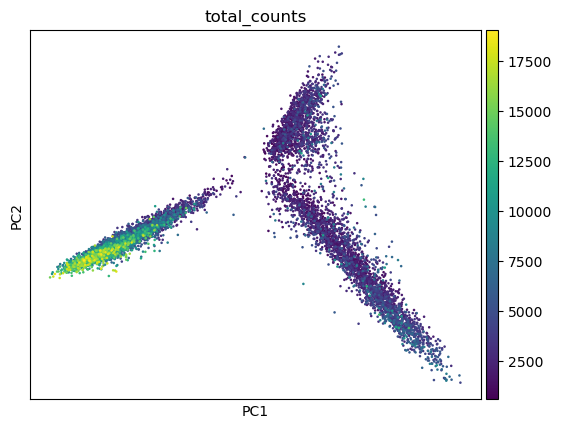

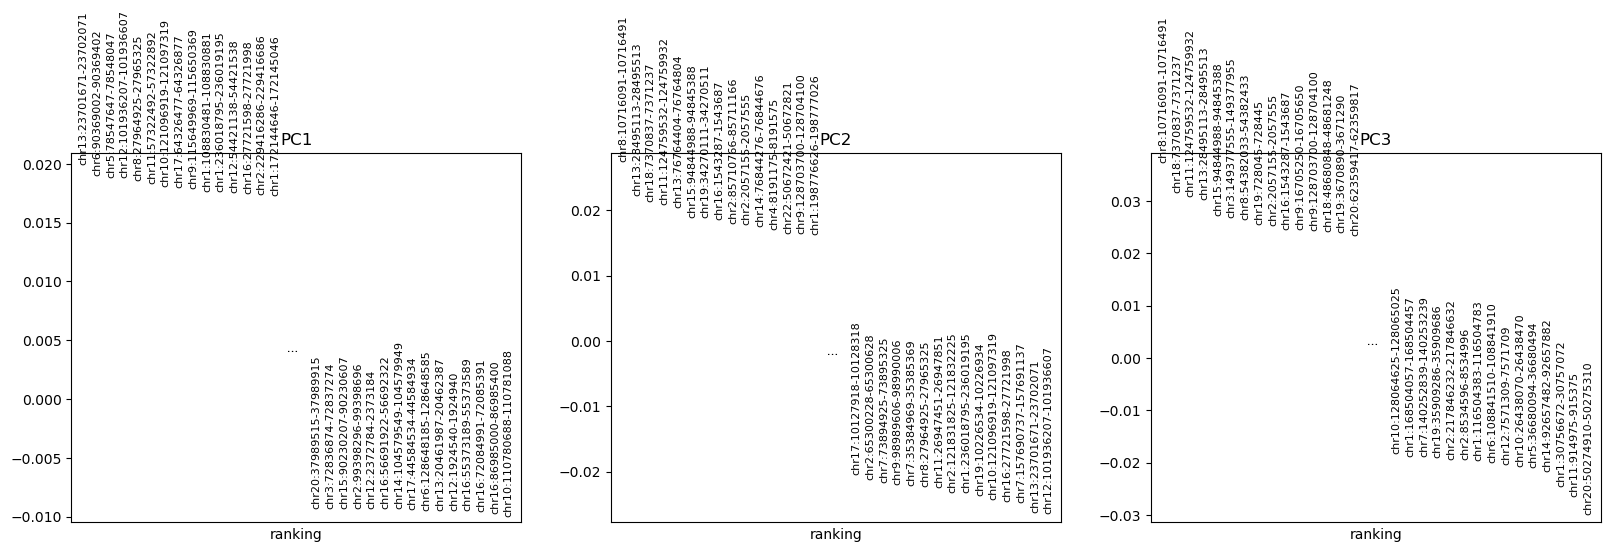

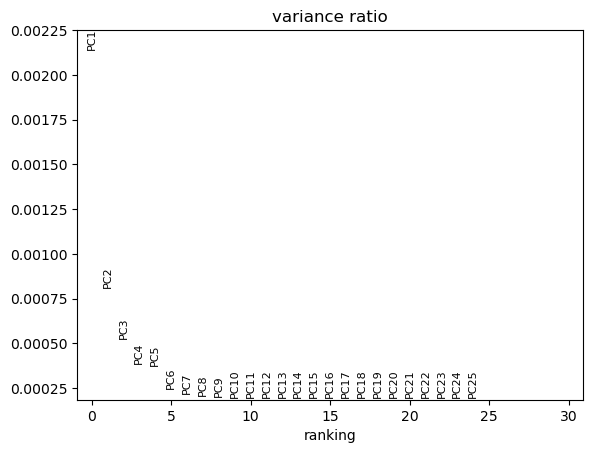

In [32]:
sc.pl.pca_overview(adata, color="total_counts")

In [33]:
%%time
sc.pp.neighbors(adata, n_neighbors= n_neighbors, method= neighbors_method, metric= neighbors_metric)

CPU times: user 36.4 s, sys: 927 ms, total: 37.4 s
Wall time: 36.1 s


In [34]:
%%time
sc.tl.umap(adata, min_dist= umap_minDist, spread= umap_spread)

CPU times: user 17.9 s, sys: 989 ms, total: 18.9 s
Wall time: 17.7 s


<Axes: title={'center': 'log1p_n_genes_by_counts'}, xlabel='UMAP1', ylabel='UMAP2'>

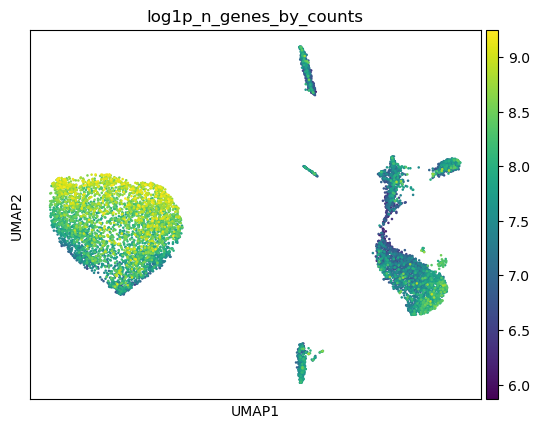

In [35]:
sc.pl.embedding(adata, basis='umap', ncols=3, show=False, color="log1p_n_genes_by_counts")

### 7. Compute Clusters 

In [36]:
%%time
# Compute clusters, Calculate ari-, ami- and ragi-score

if "clusters" not in adata.uns:
    adata.uns["clusters"] = dict()

ragi_reference = utils.ragi(adata, 'ontology label')
adata.uns["ragi_reference"] = ragi_reference

for method, value in cluster_params:
    tag = f'{method}_{value}'
    
    # calculate clusters
    if method == 'louvain':
        sc.tl.louvain(adata, resolution=value, key_added=tag)
    elif method == 'leiden':
        sc.tl.leiden(adata, resolution=value, key_added=tag)
    elif method == 'kmeans':
        epi.tl.kmeans(adata, num_clusters=value)
        adata.obs[tag] = adata.obs["kmeans"]
        del adata.obs["kmeans"]
        adata.obs[tag] = adata.obs[tag].astype(str)
        adata.obs[tag] = adata.obs[tag].astype('category')
    else:
        print("unknown method: {method}")
        
    # calculate scores
    ari = epi.tl.ARI(adata, tag, 'ontology label')
    ami = epi.tl.AMI(adata, tag, 'ontology label')
    ragi = utils.ragi(adata, tag)
    
    # save metadata
    adata.uns["clusters"][tag] = {
        "method": method,
        "param": {
           "n_clusters" if method == "kmeans" else "resolution": value 
        },
        "score": {
            "ari": ari,
            "ami": ami,
            "ragi": ragi
        }
    }

CPU times: user 20min 20s, sys: 17.6 s, total: 20min 38s
Wall time: 20min 10s


In [37]:
adata.uns["clusters"]

{'louvain_0.1': {'method': 'louvain',
  'param': {'resolution': 0.1},
  'score': {'ari': 0.9452679403121834,
   'ami': 0.8891405845172708,
   'ragi': 0.6561079308341948}},
 'louvain_0.25': {'method': 'louvain',
  'param': {'resolution': 0.25},
  'score': {'ari': 0.6516282818222876,
   'ami': 0.8069301481489606,
   'ragi': 0.6775548845380787}},
 'louvain_0.5': {'method': 'louvain',
  'param': {'resolution': 0.5},
  'score': {'ari': 0.5419663370277036,
   'ami': 0.7758621282257258,
   'ragi': 0.7049000418945205}},
 'louvain_1': {'method': 'louvain',
  'param': {'resolution': 1},
  'score': {'ari': 0.37522301984257184,
   'ami': 0.7103505305765405,
   'ragi': 0.7118441754191817}},
 'leiden_0.1': {'method': 'leiden',
  'param': {'resolution': 0.1},
  'score': {'ari': 0.9564949728018278,
   'ami': 0.9037513731961084,
   'ragi': 0.7108162538144726}},
 'leiden_0.25': {'method': 'leiden',
  'param': {'resolution': 0.25},
  'score': {'ari': 0.6503200186368354,
   'ami': 0.8079154490524483,
   '

In [38]:
# Find cluster with best ari-score, and save as "best_cluster" 

best_tag, best_ari = None, 0
for tag in adata.uns["clusters"]:
    ari = adata.uns["clusters"][tag]["score"]["ari"]
    if ari > best_ari:
        best_tag = tag
        best_ari = ari
print(best_tag, best_ari)
adata.uns["best_cluster"] = best_tag

leiden_0.1 0.9564949728018278


In [39]:
# Find cluster with best ragi-score, and save as "best_cluster_ragi" 

best_tag, best_ragi = None, 0
for tag in adata.uns["clusters"]:
    ragi = adata.uns["clusters"][tag]["score"]["ragi"]
    if ragi > best_ragi:
        best_tag = tag
        best_ragi = ragi
print(best_tag, best_ragi)
adata.uns["best_cluster_ragi"] = best_tag

kmeans_16 0.7954747288475811


<Axes: title={'center': 'leiden_0.1'}, xlabel='UMAP1', ylabel='UMAP2'>

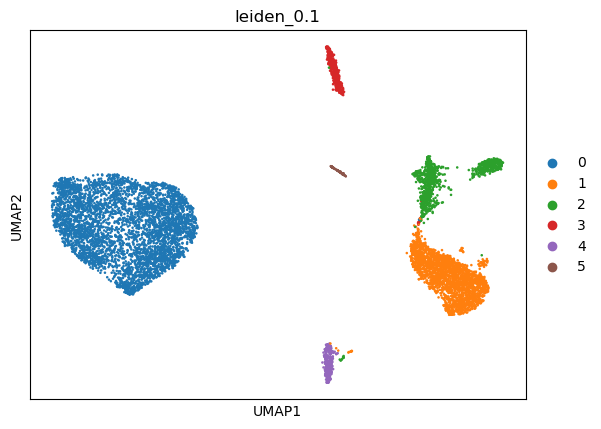

In [40]:
sc.pl.embedding(adata, basis='umap', ncols=3, show=False, color=adata.uns["best_cluster"])

<Axes: title={'center': 'ontology label'}, xlabel='UMAP1', ylabel='UMAP2'>

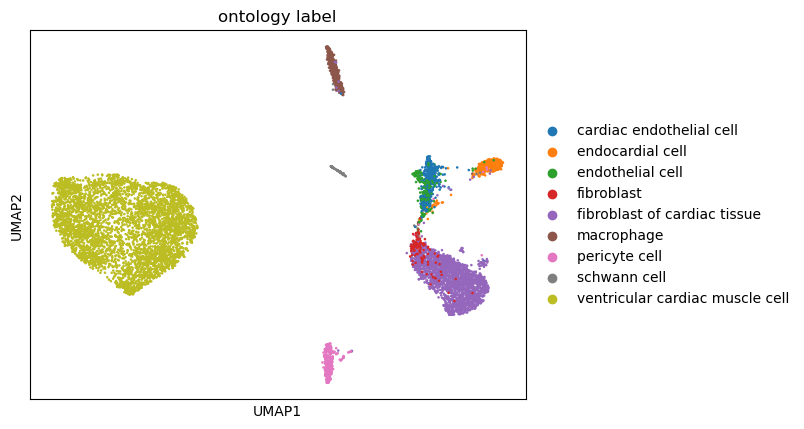

In [41]:
# Reference for comparison
sc.pl.embedding(adata, basis='umap', ncols=3, show=False, color=["ontology label"])

### 8. Export data

In [47]:
# Remove unannotated regions 
adata_genes = adata[:, ~adata.var['gene_name'].isna()]

In [48]:
# save adata.X in sparse column format for faster access of regions
values_csc = adata_genes.X.tocsc()

In [54]:
# group regions by gene_name, and keep the highest gini-score per cluster
var_export = adata_genes.var.groupby(by="gene_name").aggregate({ f"{c}_gini_scores": "max" for c in adata_genes.uns["clusters"]})

In [55]:
%%time
merged_data_dict = {}

for gene in var_export.index:
    # calulate where the associated regions are
    gene_regions = np.flatnonzero(adata_genes.var['gene_name'] == gene)

    # get the data from adata.X for the regions
    data_slice = values_csc[:, gene_regions]
    
    # The data_slice contains one column per associated region, and one row per cell.
    # For exporting it's required to merge the columns into one.
    # To achieve this, the max of the rows is taken.
    
    # I.e. if we have two regions, one with a peak (value != 0), one without (value == 0), 
    # the maximum is the value of the peak.  
    merged = data_slice.max(axis=1)
    merged_data_dict[gene] = merged

CPU times: user 40.8 s, sys: 124 ms, total: 40.9 s
Wall time: 40.9 s


In [56]:
# Concatenate the columns in merged_data_dict into one csr matrix
merged_matrix = hstack(list(merged_data_dict.values()), format='csr')

In [57]:
# Build new adata
adata_export = ad.AnnData(
    X=merged_matrix, 
    obs=adata.obs, 
    obsm=adata.obsm, 
    var=var_export
)
adata_export.uns.update(adata.uns)

In [ ]:
%%time
adata_export.write(
        out_file,
        compression="gzip")